In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report
from sklearn.datasets import load_iris
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression


### Reading the data

In [3]:
df = pd.read_csv('train.csv')
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


No need for the ID attribute since it's a sequential numbering of the data and the data is already indexed.

In [20]:
df.drop(columns=['id' ], inplace = True)

KeyError: "['id'] not found in axis"

In [ ]:
dict(df.dtypes)

{'Id': dtype('int64'),
 'MSSubClass': dtype('int64'),
 'MSZoning': dtype('O'),
 'LotFrontage': dtype('float64'),
 'LotArea': dtype('int64'),
 'Street': dtype('O'),
 'Alley': dtype('O'),
 'LotShape': dtype('O'),
 'LandContour': dtype('O'),
 'Utilities': dtype('O'),
 'LotConfig': dtype('O'),
 'LandSlope': dtype('O'),
 'Neighborhood': dtype('O'),
 'Condition1': dtype('O'),
 'Condition2': dtype('O'),
 'BldgType': dtype('O'),
 'HouseStyle': dtype('O'),
 'OverallQual': dtype('int64'),
 'OverallCond': dtype('int64'),
 'YearBuilt': dtype('int64'),
 'YearRemodAdd': dtype('int64'),
 'RoofStyle': dtype('O'),
 'RoofMatl': dtype('O'),
 'Exterior1st': dtype('O'),
 'Exterior2nd': dtype('O'),
 'MasVnrType': dtype('O'),
 'MasVnrArea': dtype('float64'),
 'ExterQual': dtype('O'),
 'ExterCond': dtype('O'),
 'Foundation': dtype('O'),
 'BsmtQual': dtype('O'),
 'BsmtCond': dtype('O'),
 'BsmtExposure': dtype('O'),
 'BsmtFinType1': dtype('O'),
 'BsmtFinSF1': dtype('int64'),
 'BsmtFinType2': dtype('O'),
 'BsmtF

### Check for duplicates

In [26]:
df.duplicated().sum()

0

### Checking for nulls

In [21]:
df.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [14]:
for col in df:
    if (df[col].isnull().sum() > 0):
        print(col,":", df[col].isnull().sum())

LotFrontage : 259
Alley : 1369
MasVnrType : 8
MasVnrArea : 8
BsmtQual : 37
BsmtCond : 37
BsmtExposure : 38
BsmtFinType1 : 37
BsmtFinType2 : 38
Electrical : 1
FireplaceQu : 690
GarageType : 81
GarageYrBlt : 81
GarageFinish : 81
GarageQual : 81
GarageCond : 81
PoolQC : 1453
Fence : 1179
MiscFeature : 1406


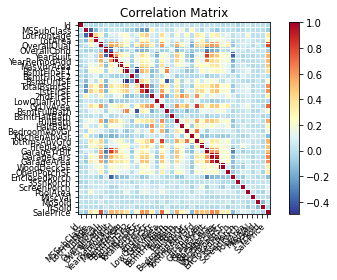

In [32]:
import statsmodels.api as sm
correlarion= df.corr()
sm.graphics.plot_corr(correlarion, xnames=list(correlarion.columns))
plt.show()

#wtf is this

In [ ]:
#should we impute the missing values of (MasVnrType) with none? MasVnrArea? BsmtCond with none? BsmtExposure? BsmtFinType1 NA? BsmtFinType2 NA? Drop Electrical? FireplaceQu? 

In [5]:
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [ ]:
X = df.iloc[:,0:-1]
y = pd.DataFrame(data=df['SalesPrice'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline


rmse_val = []
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train, y_train)
    pred=model.predict(X_test)
    error = sqrt(mean_squared_error(y_test,pred))
    rmse_val.append(error)
    print('RMSE value for k= ' , K , 'is:', error)

In [ ]:
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()


In [ ]:
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}

knn = neighbors.KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=5)
model.fit(X_train,y_train)
model.best_params_

In [ ]:
X = df.iloc[:, 0].values.reshape(-1, 1) 
Y = df.iloc[:, 1].values.reshape(-1,1) 
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)